In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time

import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

def BoltzmannWeight_local(spins, sitex, sitey, K, h, T, dop_spacing):
  sum=0

  K_dop_val=2*K/T
  K_reg_val=1*K/T
    #assumes non periodic boundary conditions, should be fine to ignore in the large N limit
  if sitex % dop_spacing ==0 and sitey % dop_spacing ==0:
    K=K_dop_val
  else:
    K=K_reg_val
  if sitex == (len(spins)-1)  and sitey != len(spins)-1  and sitey !=0:
    #sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitey == len(spins)-1  and sitex != len(spins)-1 and sitex !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    #sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitex ==0  and sitey != len(spins)-1 and sitey !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    #sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitey==0 and sitex != len(spins)-1 and sitex !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    #sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))
  if sitex != len(spins)-1 and sitey != len(spins)-1 and sitex !=0 and sitey !=0:
    sum+=((K*spins[sitex][sitey]*spins[sitex+1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex-1][sitey]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey+1]))
    sum+=((K*spins[sitex][sitey]*spins[sitex][sitey-1]))

  sum+=((h*spins[sitex][sitey]))
            #print(sum)
    #print(sum)
  BW=np.exp(sum)
  return BW




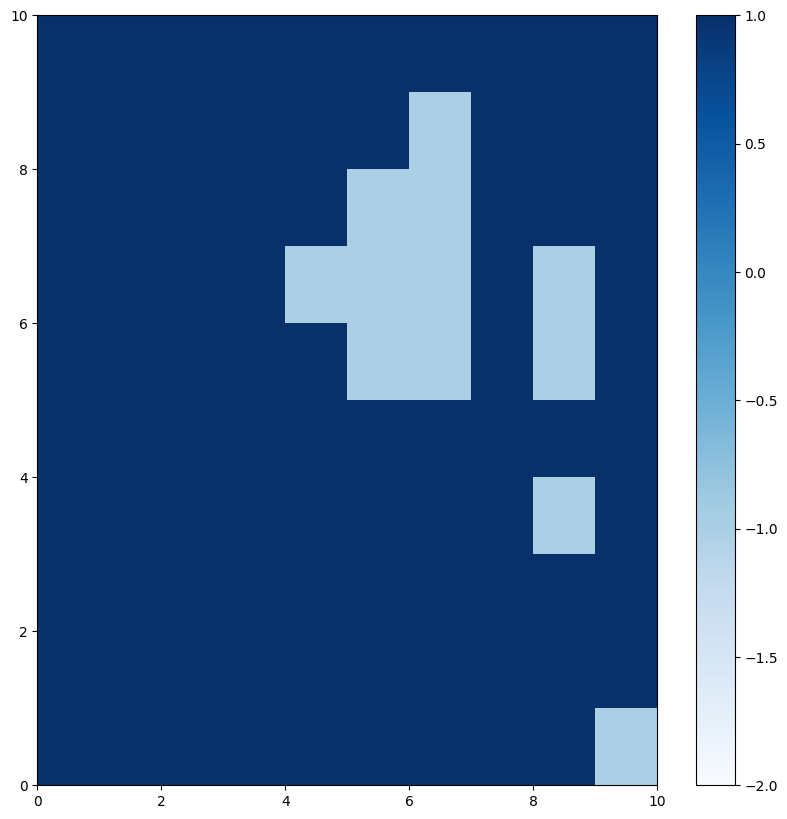

In [47]:
def genSamples_hits_dopants_proportional_GM(N_lattice, num_samples, K, h, T, dop_spacing, E_in, hit_time):
 
    samples = np.zeros([num_samples, N_lattice, N_lattice]) # where you will store your samples
    hit_sitex=int(N_lattice/2)
    hit_sitey=int(N_lattice/2)
    for i in range((num_samples)):
      if i==0:
        #creat the lattice at "time step 1"
        spin_start= np.ones([N_lattice, N_lattice])
        
        samples[0]= spin_start
      if i>0:
        #samples[i]=samples[i-1]
        spin_start= samples[i-1].copy()
        #print(i, samples[i-1]-samples[i-2])
      if i==hit_time: #put the particle hit at time step hit_time
        #samples[i]=spin_start
        spin_start= samples[i-1].copy()
        #print(i, samples[i-1]-samples[i-2])
        hit_sitex=int(N_lattice/2)
        hit_sitey=int(N_lattice/2)
        spin_start[hit_sitex, hit_sitey]= -1
        num_to_flip=E_in-1

        k=0 #make possible sites in a square
        sites=np.zeros([(int(np.sqrt(E_in))+1)**2, 2])
        for s_x in range(int(np.sqrt(E_in))+1): #s is number of particles ionized
          for s_y in range(int(np.sqrt(E_in))+1):
            sites[k] =[hit_sitex+s_x, hit_sitey+s_y]
            k+=1

        j=0 # only flip a number of them proportional to E_in
        while j <= num_to_flip:  
          sitex=int(sites[j][0])
          sitey=int(sites[j][1])
          spin_start[sitex,sitey]= -1
          j+=1
          #print(j, num_to_flip, hit_sitex, hit_sitey)

        samples[i]=spin_start
      
      for n in range(N_lattice**2): #number of possible flips
        #spin_start= samples[i]

        site= np.random.choice(N_lattice), np.random.choice(N_lattice)
        if i==hit_time and site== (hit_sitex, hit_sitey):
          site= np.random.choice(N_lattice), np.random.choice(N_lattice)
        #print(i, spin_start[site])
        #define the flipped spin_start
        pos_flip=spin_start.copy()
        #print(pos_flip[site])
        if pos_flip[site]==1:
          pos_flip[site]=-1

        else:
          pos_flip[site]=1
        #pos_flip[site]=-1*spin_start.copy()[site]
        #determine probability of flip - random num gen >A dont flip, random num gen < A, flip
        
          #print(A, prob, 'no flip')

        if i>=hit_time:
          site_nearby= (hit_sitex+np.random.randint(-int(np.sqrt(E_in)+i), int(np.sqrt(E_in)+i)), hit_sitey+np.random.randint(-int(np.sqrt(E_in)+i), int(np.sqrt(E_in)+i)))
          if site_nearby[0]<(N_lattice-1) and site_nearby[1]<(N_lattice-1) and site_nearby[0]>0 and site_nearby[1]>0:
            if pos_flip[site_nearby]==1:
              pos_flip[site_nearby]=-1
          A= BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing)/BoltzmannWeight_local(spin_start, site[0], site[1], K, h, T, dop_spacing)
          A=np.min([1,A])
        
          prob =np.random.rand(1,1)
          #noise_prob=0.01*T #noise increases as temperature increases


          if prob <=A:
            spin_start = pos_flip
            
          else:
            spin_start =spin_start


      samples[i]=spin_start
    return samples


N_lattice=10
E_test=10
prop_samp= genSamples_hits_dopants_proportional_GM(N_lattice, 2, 1,1,1,5,E_test, 1)
fig, ax = plt.subplots(figsize=(N_lattice, N_lattice))
ax.set(xlim=(0,N_lattice ), ylim=(0, N_lattice))

cax = ax.pcolormesh(prop_samp[1],vmin=-2, vmax=1, cmap=plt.cm.Blues)
fig.colorbar(cax)

In [48]:
#temp=np.linspace(1,1.5,10)
N_lattice = 100

n_samp=100
K=100
T=1
hit_time=20
E_hit=10
dop_spacing=5
h=1

test_dop_hits_GM= genSamples_hits_dopants_proportional_GM(N_lattice,n_samp, K, h, T, dop_spacing, E_hit, hit_time)

#print(len(test_dop_hits))

/var/folders/38/nh9v69ds38g0qknv680zrsj40000gn/T/ipykernel_28600/2381483305.py:47: RuntimeWarning: overflow encountered in exp
  BW=np.exp(sum)
/var/folders/38/nh9v69ds38g0qknv680zrsj40000gn/T/ipykernel_28600/3305437010.py:67: RuntimeWarning: overflow encountered in scalar divide
  A= BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing)/BoltzmannWeight_local(spin_start, site[0], site[1], K, h, T, dop_spacing)


In [98]:
#dead time as a function of temperature
def dead_time(spins, hit_time):
    time_0=hit_time
    
    for time_step in range(len(spins)-hit_time):
      time_step+=hit_time
      #print( np.sum(spins[time_step]))
      if np.abs((N_lattice**2-np.sum(spins[time_step]))/2)<=0.001*N_lattice**2: 
          #print(np.abs((N_lattice**2-np.sum(spins[time_step]))/2)/(N_lattice**2))
          time_stop= time_step
          dead_time= time_stop-time_0
          #print(dead_time)
          break
          continue
          
    return dead_time 

E_hit=1
test_dop_hits= genSamples_hits_dopants_proportional_GM(N_lattice,200, K, 1, T, 5, E_hit, hit_time)        
dead_time(test_dop_hits, hit_time)

/var/folders/38/nh9v69ds38g0qknv680zrsj40000gn/T/ipykernel_28600/2381483305.py:47: RuntimeWarning: overflow encountered in exp
  BW=np.exp(sum)
/var/folders/38/nh9v69ds38g0qknv680zrsj40000gn/T/ipykernel_28600/3305437010.py:67: RuntimeWarning: overflow encountered in scalar divide
  A= BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing)/BoltzmannWeight_local(spin_start, site[0], site[1], K, h, T, dop_spacing)


34

/var/folders/38/nh9v69ds38g0qknv680zrsj40000gn/T/ipykernel_28600/2381483305.py:47: RuntimeWarning: overflow encountered in exp
  BW=np.exp(sum)
/var/folders/38/nh9v69ds38g0qknv680zrsj40000gn/T/ipykernel_28600/3305437010.py:67: RuntimeWarning: overflow encountered in scalar divide
  A= BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing)/BoltzmannWeight_local(spin_start, site[0], site[1], K, h, T, dop_spacing)
/var/folders/38/nh9v69ds38g0qknv680zrsj40000gn/T/ipykernel_28600/3305437010.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  A= BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing)/BoltzmannWeight_local(spin_start, site[0], site[1], K, h, T, dop_spacing)
/var/folders/38/nh9v69ds38g0qknv680zrsj40000gn/T/ipykernel_28600/3305437010.py:67: RuntimeWarning: invalid value encountered in scalar divide
  A= BoltzmannWeight_local(pos_flip, site[0], site[1], K, h, T, dop_spacing)/BoltzmannWeight_local(spin_start, site[0], site[1], K, 

3.111111111111111 27.3
5.222222222222222 26.5
7.333333333333334 27.0
9.444444444444445 26.5
11.555555555555555 26.4
13.666666666666668 27.3
15.777777777777779 26.3
17.88888888888889 26.3
20.0 27.2


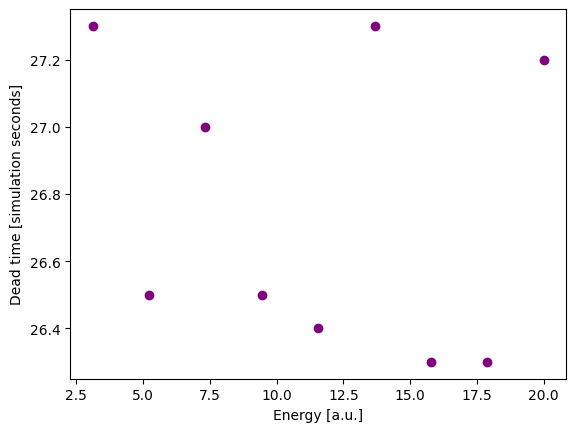

In [106]:
N_lattice = 50
n_samp=100
K=100
T=1
hit_time=5
E_hits=np.linspace(1,20,10)

num_runs= 10
for E in E_hits: 
  dead_time_runs=0
  for r in range(num_runs):     
    test_dop_hits= genSamples_hits_dopants_proportional_GM(N_lattice,n_samp, K, 1, T, 5, E, hit_time)        
    dead_time_runs+=dead_time(test_dop_hits, hit_time)
  dead_time_avg = dead_time_runs/num_runs
  if E !=1 and E !=2:
    print(E, dead_time_avg)
    plt.scatter(E, dead_time_avg, color='purple')

plt.xlabel('Energy [a.u.]')
plt.ylabel('Dead time [simulation seconds]')
plt.show()


In [49]:

fig, ax = plt.subplots(figsize=(N_lattice, N_lattice))
ax.set(xlim=(0,N_lattice ), ylim=(0, N_lattice))

cax = ax.pcolormesh(test_dop_hits_GM[0],vmin=-2, vmax=1, cmap=plt.cm.Blues)
fig.colorbar(cax)

def animate(i):
     cax.set_array(test_dop_hits_GM[i].flatten())
     
     if i==hit_time:
          ax.set_title(f"time = {i}, temp= {T}, K= {K}, hit, hit energy= {E_hit}", fontsize=60)
     else:
          ax.set_title(f"time = {i}, temp= {T}, K= {K}", fontsize=60)
          
     #ttl = ax.text(0.5, 1.005, i, transform = ax.transAxes, va='center', fontsize= 'medium')
     return cax


anim = FuncAnimation(fig, animate, interval=400, frames=(n_samp))

anim.save('Ising_model_detector_GM_100N_E10.gif', writer = "pillow", fps=5)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
def magnetization(spins_array):
    mag_vals = np.zeros(len(spins_array))
    tot_sites= N_lattice**2
    for i in range(len(spins_array)):
        mag_vals[i] = np.sum(spins_array[i])
    
    return np.abs((mag_vals-tot_sites)/tot_sites)*100


times=np.arange(0, len(test_dop_hits_GM))
temps= [1,2,3]
num_runs= 100


for t in temps: 
    mag= np.zeros([num_runs, n_samp])
    magnet=np.zeros(n_samp)
    for r in range(num_runs):
        test_dop_hits= genSamples_hits_dopants_GM(N_lattice,n_samp, K, 1, t, 5, E_hit, hit_time)
        #print(len(magnetization(test_dop_hits)))
        mag[r,]= magnetization(test_dop_hits) 
        #print(mag)
    
        magnet+=mag[r]
    magnet=magnet/num_runs
    #print(magnet)
    plt.plot(times, magnet, label=f"temp= {t}")


plt.xlabel('time step')
plt.ylabel('Number of atoms ionized [% of total atoms]')
plt.axvline(hit_time, 0, mag.max(), label="particle hit", color='purple', linestyle='--')
plt.legend()
plt.title(f"Lattice Size {N_lattice}x{N_lattice}, hit energy {E_hit}, number of runs per temp {num_runs} ")


